# Wikipedia monthly traffic analysis

In this notebook, we will gather monthly page view data from Wikipedia and perform some simple data analysis.

## Step 1: Data acquisition

In this step we will call the Wikipedia APIs to obtain traffic data for desktop and mobile domains from Jan 2008 to Sep 2021. We will need to call 2 different API endpoints to cover the time range we need, they are: 

  * The Legacy Pagecounts API (Jan 2008 to July 2016)
  * The Pageviews API (July 2015 to Aug 2021)
  
For each API and domain, we will store the raw results directly in files under `../raw-data/`

In [1]:
import json
import requests

Here we define methods to generate configurations for API calls for given start/end dates and accesstype (website, mobile, etc.)

In [2]:
def configure_endpoint_legacy(start_date, end_date, access_type):
    # This method creates endpoint configuration for the legacy API with given start/end dates and access_type
    # see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
    example_params_legacy = {"project" : "en.wikipedia.org",
                     "access-site" : access_type,
                     "granularity" : "monthly",
                     "start" : start_date,
                     # for end use 1st day of month following final month of data
                     "end" : end_date
                        }
    
    endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

    return endpoint_legacy.format(**example_params_legacy)

def configure_endpoint_pageviews(start_date, end_date, access_type):
    # This method creates endpoint configuration for the pageview API with given start/end dates and access_type
    # see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
    params_pageviews = {"project" : "en.wikipedia.org",
                        "access" : access_type,
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : start_date,
                         # for end use 1st day of month following final month of data
                         "end" : end_date
                            }
    
    endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
    
    return endpoint_pageviews.format(**params_pageviews)

    
headers = {
    'User-Agent': 'https://github.com/wanggy0201',
    'From': 'wanggy@uw.edu'
}

Here we define methods to execute API calls with given configurations and store the result into files

In [3]:
def api_call(config, headers):
    call = requests.get(config, headers=headers)
    response = call.json()
    
    return response

def call_api_and_save(start_date, end_date, access_type, headers, output_dir, is_legacy):
    if is_legacy:
        config = configure_endpoint_legacy(start_date, end_date, access_type)
        filename = "legacy_" + access_type + "_" + start_date[:-4] + "-" + end_date[:-4] + ".json"
    else:
        config = configure_endpoint_pageviews(start_date, end_date, access_type)
        filename = "pageviews_" + access_type + "_" + start_date[:-4] + "-" + end_date[:-4] + ".json"
        
    response = api_call(config, headers)

    with open(output_dir + filename, 'w') as fp:
        json.dump(response, fp, sort_keys=True)
    
    print(filename)
    return filename
    

In this block we will call both APIs with the following configurations:

* Legacy - Jan 2008 to July 2016 - desktop
* Legacy - Jan 2008 to July 2016 - mobile
* Pageviews - July 2015 to Aug 2021 - desktop
* Pageviews - July 2015 to Aug 2021 - mobile-app
* Pageviews - July 2015 to Aug 2021 - mobile-web


In [4]:
raw_data_output_dir = "../raw-data/"

raw_data_files = [ 
    call_api_and_save("2008010100", "2016080100", "desktop-site", headers, raw_data_output_dir, is_legacy=True),
    call_api_and_save("2008010100", "2016080100", "mobile-site", headers, raw_data_output_dir, is_legacy=True),
    call_api_and_save("2015070100", "2021090100", "desktop", headers, raw_data_output_dir, is_legacy=False),
    call_api_and_save("2015070100", "2021090100", "mobile-app", headers, raw_data_output_dir, is_legacy=False),
    call_api_and_save("2015070100", "2021090100", "mobile-web", headers, raw_data_output_dir, is_legacy=False)
]

legacy_desktop-site_200801-201608.json
legacy_mobile-site_200801-201608.json
pageviews_desktop_201507-202109.json
pageviews_mobile-app_201507-202109.json
pageviews_mobile-web_201507-202109.json


## Step 2: Data processing

In this step we will convert the raw data that we obtained from the last step to a flattened Pandas dataframe and store it as a csv file under `../processed-data`

In [5]:
import pandas as pd
from functools import reduce

Here we implement a method to convert the raw json file to a Pandas dataframe

In [6]:
def raw_file_to_df(file_path):
    with open(file_path) as f:
        data = json.load(f)
        
    df = pd.DataFrame.from_dict(data['items'])
    
    df['year'] = df['timestamp'].str[0:4]
    df['month'] = df['timestamp'].str[5:6]
    df['date'] = df.agg('{0[year]}-{0[month]}'.format, axis=1)
    
    if 'legacy' in file_path:
        access_site = df['access-site'].unique()[0]
        assert(len(df['access-site'].unique()) == 1)
        
        count_col_name = 'pagecount_' + access_site
        df[count_col_name] = df['count']
    else:
        access_site = df['access'].unique()[0]
        assert(len(df['access'].unique()) == 1)
        
        count_col_name = 'pageview_' + access_site
        df[count_col_name] = df['views']
    
    # Note: We will drop duplicates here to aviod duplicate dates, and will keep the last record since we don't know which one should be used
    df = df[['year', 'month', 'date', count_col_name]].drop_duplicates(subset='date', keep="last")
    return df

In [7]:
dfs = [raw_file_to_df(raw_data_output_dir + file_name) for file_name in raw_data_files]

Here we outer join all the processed dataframes with column year, month and date.

In [8]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['year', 'month', 'date'], how='outer'), dfs)

Renaming columns to the required schema

In [9]:
df_merged['pageview_mobile_views'] = df_merged['pageview_mobile-app'] + df_merged['pageview_mobile-web']

df_merged['pageview_desktop_views'] = df_merged['pageview_desktop'] 
df_merged['pagecount_desktop_views'] = df_merged['pagecount_desktop-site'] 
df_merged['pagecount_mobile_views'] = df_merged['pagecount_mobile-site'] 

df_merged['pageview_all_views'] = df_merged['pageview_mobile_views'] + df_merged['pageview_desktop_views']
df_merged['pagecount_all_views'] = df_merged['pagecount_desktop_views'] + df_merged['pagecount_mobile_views']

df_merged = df_merged[[
    'year', 
    'month', 
    'date',
    'pagecount_all_views', 
    'pagecount_desktop_views', 
    'pagecount_mobile_views',
    'pageview_all_views',
    'pageview_desktop_views',
    'pageview_mobile_views'
]]

In [10]:
df_merged

,year,month,date,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,3,2008-3,NaN,4.955406e+09,NaN,NaN,NaN,NaN
1,2008,4,2008-4,NaN,5.159162e+09,NaN,NaN,NaN,NaN
2,2008,5,2008-5,NaN,5.584691e+09,NaN,NaN,NaN,NaN
3,2008,6,2008-6,NaN,5.712104e+09,NaN,NaN,NaN,NaN
4,2008,7,2008-7,NaN,5.306303e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
133,2021,4,2021-4,NaN,NaN,NaN,7.641810e+09,2.882714e+09,4.759095e+09
134,2021,5,2021-5,NaN,NaN,NaN,7.800996e+09,2.824416e+09,4.976580e+09
135,2021,6,2021-6,NaN,NaN,NaN,7.090482e+09,2.505971e+09,4.584510e+09
136,2021,7,2021-7,NaN,NaN,NaN,7.544494e+09,2.765584e+09,4.778909e+09


We will fill NaN with zeros and store the csv. Note that the fill NaN will not be passed to the data analysis step

In [11]:
df_merged.fillna(0).to_csv('../processed-data/en-wikipedia_traffic_200712-202108.csv')

## Step 3: Data analysis

In this step we will visualize the dataset that we obtained from pervious steps, by plotting out the page view counts obtained through the 2 different APIs for the different access types as time series.

In [12]:
import matplotlib.pyplot as plt

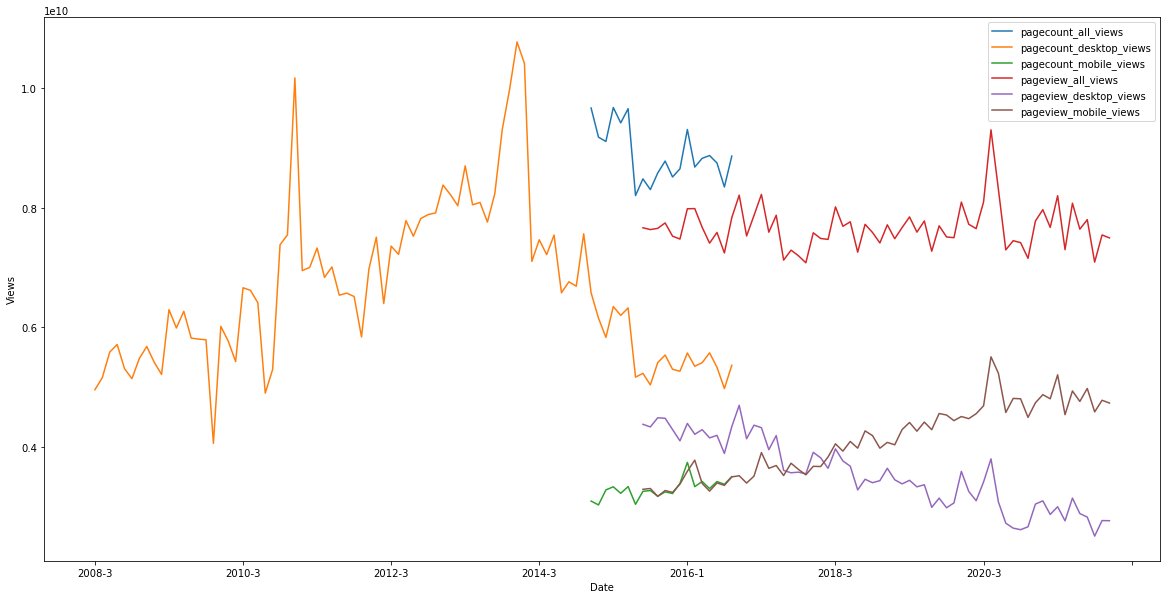

<Figure size 432x288 with 0 Axes>

In [13]:
ax = plt.gca()

df_merged.plot(kind='line',x='date',
               y=['pagecount_all_views', 
                    'pagecount_desktop_views', 
                    'pagecount_mobile_views',
                    'pageview_all_views',
                    'pageview_desktop_views',
                    'pageview_mobile_views'],
               ax=ax,
              figsize=(20, 10))

ax.set_xlabel("Date")
ax.set_ylabel("Views")

plt.show()
plt.savefig('../results/trends.png')
